# Feature 1:  Market quotes

In [82]:
import pandas as pd
import hmac
import time
import hashlib
import requests
from urllib.parse import urljoin, urlencode

from pandas import json_normalize

In [83]:
# for future market

# Future
# BASE_URL = 'https://fapi.binance.com' 

# Spot margin Saving Mining
BASE_URL = 'https://api.binance.com'


''' ======  begin of functions, you don't need to touch ====== '''
def hashing(query_string):
    return hmac.new(SECRET.encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256).hexdigest()

def get_timestamp():
    return int(time.time() * 1000)


def dispatch_request(http_method):
    session = requests.Session()
    session.headers.update({
        'Content-Type': 'application/json;charset=utf-8',
        'X-MBX-APIKEY': KEY
    })
    return {
        'GET': session.get,
        'DELETE': session.delete,
        'PUT': session.put,
        'POST': session.post,
    }.get(http_method, 'GET')

# used for sending request requires the signature
def send_signed_request(http_method, url_path, payload={}):
    query_string = urlencode(payload, True)
    
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, get_timestamp())
    else:
        query_string = 'timestamp={}'.format(get_timestamp())

    url = BASE_URL + url_path + '?' + query_string + '&signature=' + hashing(query_string)
    # print("{} {}".format(http_method, url))
    params = {'url': url, 'params': {}}
    response = dispatch_request(http_method)(**params)
    return response.json()

# used for sending public data request
def send_public_request(url_path, payload={}):
    query_string = urlencode(payload, True)
    url = BASE_URL + url_path
    if query_string:
        url = url + '?' + query_string
    # print("{}".format(url))
    # response = dispatch_request('GET')(url=url)
    response = requests.get(url)
    return response.json()

''' ======  end of functions ====== '''

## exchange info

In [85]:
symbol = 'BTCUSDT'
quantity = 0.003

# params = {
#     'symbol': symbol,
#     'side': 'SELL',
#     'type': 'MARKET',
#     'quantity': quantity,
# }

params = {
    
}

url_path = '/api/v3/exchangeInfo'

response = send_public_request(url_path, params)

# json_normalize(response['symbols'])

## Kline/Candlestick Data

In [86]:
import datetime

def kline_data(stime, etime, symbol = 'BTCUSDT', interval = '1d'):
    
    stimestamp = int(datetime.datetime.strptime(stime, "%Y-%m-%d").timestamp()*1000)
    etimestamp = int(datetime.datetime.strptime(etime, "%Y-%m-%d").timestamp()*1000)

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': stimestamp,
        'endTime': etimestamp,
        'limit': 1000,
    }

    url_path = '/api/v3/klines'

    response = send_public_request(url_path, params)

    data = pd.DataFrame(response)

    col = ['Open_time','Open','High','Low','Close','Volume','Close_time','Quote_asset_volume','Number_of_trades',
        'Taker_buy_volume','Taker_buy_quote_asset_volume','Ignore']

    data.columns = col
    #       transfer the timestamp into time
    data['Open_time'] = pd.to_datetime(data['Open_time'],unit='ms',utc=True)
    data['Close_time'] = pd.to_datetime(data['Close_time'],unit='ms',utc=True)
    
    data.iloc[:,[1,2,3,4,5,7,9,10]] = data.iloc[:,[1,2,3,4,5,7,9,10]].astype(float)
    
    return data

In [87]:
stime = "2018-12-31"
etime = "2020-01-01"
symbol = 'ETHUSDT'
interval = '1d'

data1 = kline_data(stime,etime,symbol,interval)

stime = "2020-01-01"
etime = "2022-05-01"
symbol = 'BTCUSDT'
interval = '1d'

data2 = kline_data(stime,etime,symbol,interval)

data = pd.concat([data1,data2])

In [88]:
import numpy as np

In [89]:
data['daily_return'] = data.Close/data.Open - 1
data['price_vol'] = (data.High-data.Low)/data.Open
data['log_price'] = np.log(data.Close)
data['volumn_pct'] = data.Volume.pct_change()

data.Open_time = data.Open_time.dt.strftime('%Y-%m-%d')
data.Close_time = data.Close_time.dt.strftime('%Y-%m-%d')
data = data.drop(['Ignore','Open_time'],axis=1)

In [90]:
data = data.rename(columns ={'Close_time':'date'})

In [91]:
data['Close_shift_1'] = data.Close.shift(1)
data['Close_shift_2'] = data.Close.shift(2)
data['Close_shift_3'] = data.Close.shift(3)

In [92]:
data.to_csv('MarketqutoesData/BTCUSDT_daily.csv')

# TechIndicatorsData

In [93]:
import pandas as pd
import talib as ta
import numpy as np
from FinTechTools import multiple_ta

data = pd.read_csv('MarketqutoesData/BTCUSDT_daily.csv',index_col= 0)

data.date = pd.to_datetime(data.date)
ind_list,name_list = multiple_ta(data)

data_ind = pd.DataFrame()
for i in range(len(ind_list)):
    data_ind = pd.concat([data_ind,pd.DataFrame(ind_list[i])],axis=1)
    
data_ind.columns = name_list
data_ind['date'] = data.date

# drop columns with inf values
inf_col = lambda x: sum(x == np.inf)>1 
# print(data_ind.columns[data.apply(inf_col)])
data_ind = data_ind.drop(data_ind.columns[data_ind.apply(inf_col)],axis = 1)

# Save data
data_ind.to_csv('TechIndicatorsData/All_indicator.csv')

# Blockchain Data

In [98]:
from os import walk

filenames = next(walk(f"BlockchainData/Raw data/"), (None, None, []))[2]  # [] if no file

data = pd.read_csv(f'BlockchainData/Raw data/{filenames[0]}')
data.Timestamp = pd.to_datetime(data.Timestamp)
data.Timestamp = data.Timestamp.dt.strftime('%Y-%m-%d')
data = data.groupby('Timestamp').mean().reset_index(drop=False)

for i in range(1,len(filenames)):
    f = filenames[i]
    d = pd.read_csv(f'BlockchainData/Raw data/{f}')
    d.Timestamp = pd.to_datetime(d.Timestamp)
    d.Timestamp = d.Timestamp.dt.strftime('%Y-%m-%d')
    d = d.groupby('Timestamp').mean().reset_index(drop=False)
    data = data.merge(d,on = 'Timestamp', how = 'outer')
    
data = data.sort_values(by = 'Timestamp')
data = data.rename(columns ={'Timestamp':'date'})

data.to_csv('BlockchainData/Blockchaindata.csv')

# GlobalCurrencyData

In [101]:
import pandas as pd

data = pd.read_csv('GlobalCurrencyData/Raw data/WS_XRU_D_csv_row.csv')

col = data.iloc[1,:]
col = col.str.split(':').str[0]

data = data.iloc[8:,:]
data.columns = col

major_country = ['Currency','CNY','JPY','EUR','GBP','INR','BRL','CAD','KRW']

data = data[major_country].loc[:,~data[major_country].columns.duplicated()]

data = data.rename(columns ={'Currency':'date'})

data.to_csv('GlobalCurrencyData/GlobalCurrencydata.csv')

# All data togather

In [105]:
from functools import reduce

# read data
data_blockchain = pd.read_csv('BlockchainData/Blockchaindata.csv', index_col =0)
data_globalcurrency = pd.read_csv('GlobalCurrencyData/GlobalCurrencydata.csv', index_col =0)
data_marketquotes = pd.read_csv('MarketqutoesData/BTCUSDT_daily.csv', index_col =0)
data_techindicators = pd.read_csv('TechIndicatorsData/All_indicator.csv', index_col =0)

d_ls = [data_blockchain,data_globalcurrency,data_marketquotes,data_techindicators]
data = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), d_ls).sort_values(by = "date")
## missing values of response variables
data['y_prediction'] = data.Close.shift(-1)
data['y_classification'] = (data.Close>data.Open).apply(lambda x: 'up' if x else 'down').shift(-1)
data = data.dropna(subset = ['Close','utxo-count','y_prediction','y_classification'])

data.drop('y_classification',axis = 1).to_csv('../Clean data/Prediction/ori_data_prediction.csv')
data.drop('y_prediction',axis = 1).to_csv('../Clean data/Classification/ori_data_classification.csv')

# drop columns with high proportion of missing values
ms_col = data.isna().sum()[data.isna().sum()>data.shape[0]*0.5].index
data = data.drop(ms_col,axis=1)

data = data.set_index('date',drop=True)
data = data.interpolate().dropna()

# y transformation
data.y_prediction = np.log(data.y_prediction)
data.y_classification = data.y_classification

# train test split
train_df = data[(pd.to_datetime(data.index).year < 2022)].reset_index(drop = True)
test_df = data[(pd.to_datetime(data.index).year >= 2022)].reset_index(drop = True)
X_train = train_df.iloc[:,:-2]
y_train = train_df.iloc[:,-2:]

X_test = test_df.iloc[:,:-2]
y_test = test_df.iloc[:,-2:]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train.iloc[:,:] = scaler.fit_transform(X_train)
X_test.iloc[:,:] = scaler.transform(X_test)

train_clean = pd.concat([X_train, y_train],axis=1)
test_clean = pd.concat([X_test, y_test],axis=1)

In [143]:
train_clean.drop('y_classification',axis = 1).to_csv('../Clean data/Prediction/Clean_data_train.csv')
test_clean.drop('y_classification',axis = 1).to_csv('../Clean data/Prediction/Clean_data_test.csv')
train_clean.drop('y_prediction',axis = 1).to_csv('../Clean data/Classification/Clean_data_train.csv')
test_clean.drop('y_prediction',axis = 1).to_csv('../Clean data/Classification/Clean_data_test.csv')

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../Clean data/Prediction/ori_data_prediction.csv',index_col=0)

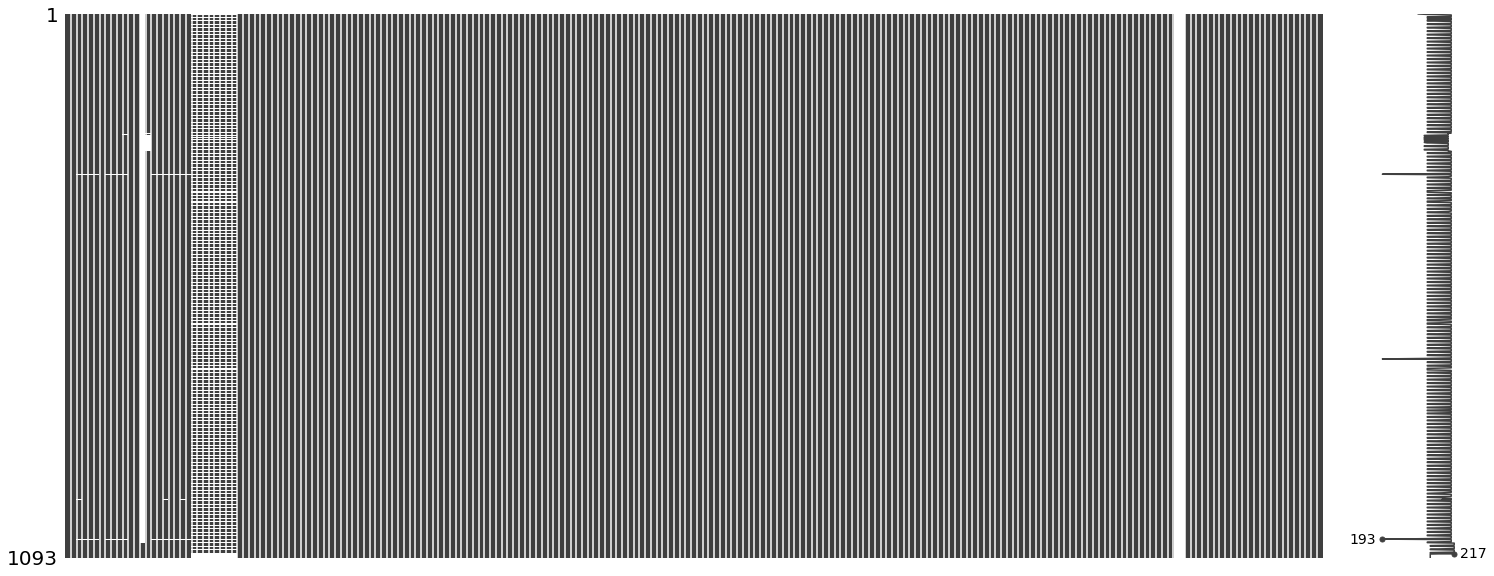

In [8]:
import matplotlib.pyplot as plt
import missingno as msno
# missing value EDA
# reference: https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/
msno.matrix(data)
plt.savefig('Missing values.png')
plt.show()